<a href="https://colab.research.google.com/github/Soulfex/Deep_Learning_Tarea2/blob/main/1_convolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolución

Extiende la operación de convolución para imágenes en escala de grises (un solo canal) vista en clase (https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2a_convolucion.ipynb) a imágenes a color (múltiples canales).

# Librerias

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
import cv2
from skimage import io

## Carga conjunto de datos
Utilizaremos una imagen a color (RGB) para este ejercicio, la descargamos desde wiki

In [21]:
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

--2022-11-07 20:10:16--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lenna_(test_image).png’

Lenna_(test_image). 100%[===================>] 462.73K  2.15MB/s    in 0.2s    

2022-11-07 20:10:16 (2.15 MB/s) - ‘Lenna_(test_image).png’ saved [473831/473831]



In [177]:
# Abrimos la imagen
img_color = cv2.imread('/content/Lenna_(test_image).png',1)
# Aplicamos un resize

# Voy a reducir la imagen para que se vea la influencia de la convolución
img_color = cv2.resize(img_color, (56,56))
#Revisamos las dimesiones
img_color.shape


(56, 56, 3)

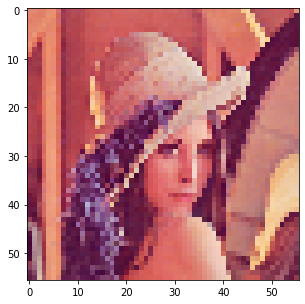

In [178]:
plt.figure(figsize=(8,5))
plt.imshow(cv2.cvtColor(img_color.astype(np.uint8), cv2.COLOR_BGR2RGB))

# Normalizamos el valor de la imagen

In [179]:
img = img_color / img_color.max()

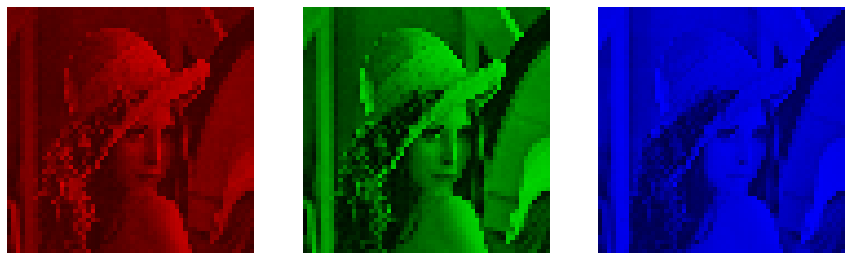

In [180]:
# Podemos ver los canales RGB
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5)) 

for c in (range(0,3)):  
    tmp_im = np.zeros(img.shape) 
    tmp_im[:,:,c] = img[:,:,c] 
    one_channel = img[:,:,c]  
    ax[c].imshow(tmp_im)  
    ax[c].set_axis_off() 
plt.show()

## Convolución y correlación cruzada
Ahora consideremos las operación de convolución entre una imagen $I$ y un filtro $W$, la cual está definida por

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto 

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n}
$$

En lugar de la convolución, frecuentemente se ocupa la operación de correlación cruzada para llevar a cabo las capas convolucionales. Esta operación es similar a la convolución pero sin voltear el filtro (por lo que pierde la propiedad de conmutatividad) y está dada por

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i + m, j + n} W_{m,n} 
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$. 

# Convolución multicanal

<img src="https://www.researchgate.net/profile/Anton-Hristov/publication/335875913/figure/fig3/AS:906271578398722@1593083390618/A-convolution-on-a-RGB-image-The-three-2D-channels-result-in-a-2D-matrix.png" width="600"/>

## Definimos la función con la que se hace la convolución

In [181]:
def conv2d(I, W, stride = 1):
  h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
  a = np.zeros((h_s, w_s))
  for i in range(h_s):
    for j in range(w_s):
      I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1]]
      a[i, j] = (I_m * W).sum()
  return a

# Esta función aplicara la convolución con el filtro a cada uno de los canales
def RGB_cov2d(I, W, b, stride = 1):
  h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
  a = np.zeros((h_s, w_s))
  for i in range(I.ndim):
    a = a + conv2d(I[:,:,i], W[:,:,i], stride)
  a = a+b
  return a
    

## Filtro

Definamos un filtro de $3 \times 3 \times 3$ que detecte bordes en cierta orientación:

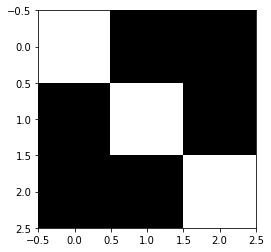

In [182]:
iden = np.identity(3)
filter1= np.zeros((3,3,3))
filter1[:,:,0] = iden
filter1[:,:,1] = iden
filter1[:,:,2] = iden
plt.imshow(filter1) 
plt.show()

In [183]:
filter1[:,:,0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

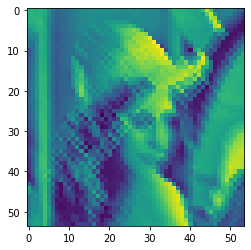

In [184]:
out = RGB_cov2d(img,filter1,0,stride = 1)
plt.imshow(out)

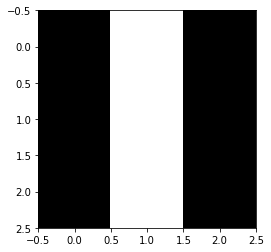

In [185]:
filter2 = np.zeros((3,3,3))
filter2[:, 1] = 1
plt.imshow(filter2, cmap = 'gray') 
plt.show()

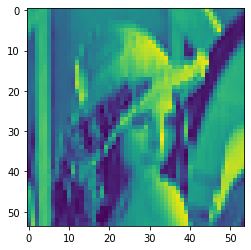

In [186]:
out2 = RGB_cov2d(img,filter2,0,stride = 1)
plt.imshow(out2)

In [191]:
# A continuación definimos el filtro sobel para 3 canales 
filter3 = np.zeros((3,3,3))
filter3[:,:,0] = np.array([[0,0,0],[0,0,0],[0,0,0]])
filter3[:,:,1] = np.array([[-1,-2,-1],[-2,-4,-2],[-1,-2,-1]])
filter3[:,:,2] = np.array([[1,2,1],[2,4,2],[1,2,1]])



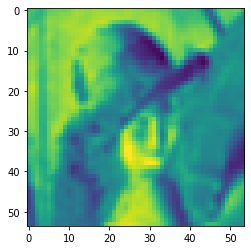

In [192]:
out3 = RGB_cov2d(img,filter3,0,stride = 1)
plt.imshow(out3)

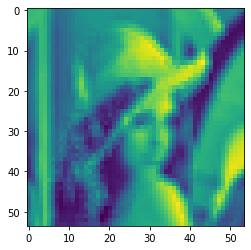

In [200]:
# Random filter

filter4 = np.random.random((3,3,3))
out4 = RGB_cov2d(img,filter4,0,stride = 1)
plt.imshow(out4)

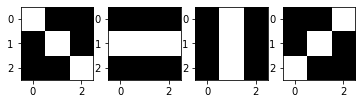

In [199]:
# Extendemos el ejemplo a 3x3x3
filters = np.zeros((4, 3, 3, 3))
filters[0, :, :, :] = filter1
filters[1, 1, :, :] = 1
filters[2, :, 1, :] = 1
filters[3, :, :, :] = filter1[::-1]

b = np.zeros(4)

plt.subplot(1,4,1)
plt.imshow(filters[0], cmap = 'gray') 
plt.subplot(1,4,2)
plt.imshow(filters[1], cmap = 'gray') 
plt.subplot(1,4,3)
plt.imshow(filters[2], cmap = 'gray') 
plt.subplot(1,4,4)
plt.imshow(filters[3], cmap = 'gray') 
plt.show()

In [194]:
def multi_conv2d(I, W, b, stride = 1):
  k = W.shape[0]
  activations = []
  for i in range(k):
    activations.append(RGB_cov2d(I, W[i], b[i], stride = 1)) 
                       
  return np.array(activations)

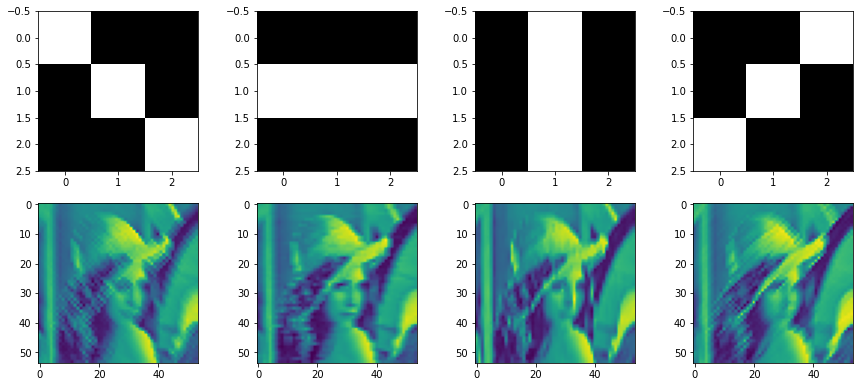

In [205]:
out_mul = multi_conv2d(img, filters, b)

plt.figure(figsize = (15, 10))
for i in range(4):
  plt.subplot(3,4,i + 1)
  plt.imshow(filters[i], cmap = 'gray')
  plt.subplot(3,4,i + 5)
  plt.imshow(out_mul[i])